# Hyperprophet Demo

Hyperprophet is a service to compute thousands of concurrent time-series forecasts in minutes using the familiar Prophet API.

In [1]:
import pandas as pd

%matplotlib inline

## The Dataset

For this demo, we are going to use a dataset pageviews of 1000 english wikipedia pages from 2019-01-01 to 2020-06-30.

In [2]:
url = "https://raw.githubusercontent.com/hyperprophet/wikipedia-pageviews-2020/master/wikipedia_pageviews.csv"

In [3]:
df = pd.read_csv(url)

In [4]:
df.article.nunique()

1000

Lets look at the top articles.

In [5]:
d = df.groupby('article').sum().sort_values('pageviews', ascending=False)

In [6]:
d.head(10)

,pageviews
article,
Main_Page,8.797164e+09
Special:Search,9.858022e+08
United_States_Senate,3.362819e+08
Donald_Trump,1.473526e+08
Wikipedia,5.929774e+07
Avengers:_Endgame,4.795992e+07
2019–20_coronavirus_pandemic,3.953119e+07
Bible,3.755880e+07
Ted_Bundy,3.369768e+07


In [7]:
top_articles = list(d.index)

## Single Forecast Using Prophet

The Facebook's prophet library can be used to forecast the pageviews an article, but forecasting all of them is cumbersome and time consuming. 

Lets first see how the forecast is done for one article using Prophet.

In [8]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [9]:
df1 = df[df.article=='Main_Page'].copy()

In [10]:
df1['date'] = pd.to_datetime(df1['date'])

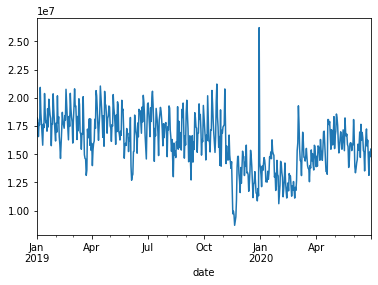

In [11]:
df1.set_index('date').pageviews.plot()

Prophet expects the column names to be `ds` and `y`. 

In [12]:
df1 = df1.rename(columns={"date": "ds", "pageviews": "y"})

In [13]:
df1 = df1[['ds', 'y']]

In [14]:
df1.head()

,ds,y
312884,2019-01-01,18056372.0
312885,2019-01-02,18216021.0
312886,2019-01-03,18019006.0
312887,2019-01-04,16561555.0
312888,2019-01-05,17738812.0


The data is ready to run forecast. 

In [15]:
m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(df1)

In [16]:
df_future = m.make_future_dataframe(periods=90)

In [17]:
df_future.head()

,ds
0,2019-01-01
1,2019-01-02
2,2019-01-03
3,2019-01-04
4,2019-01-05


In [18]:
%%time
df_forecast = m.predict(df_future)

CPU times: user 5.91 s, sys: 1.81 s, total: 7.72 s
Wall time: 2.04 s


/Users/anand/.venv/python37/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/anand/.venv/python37/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


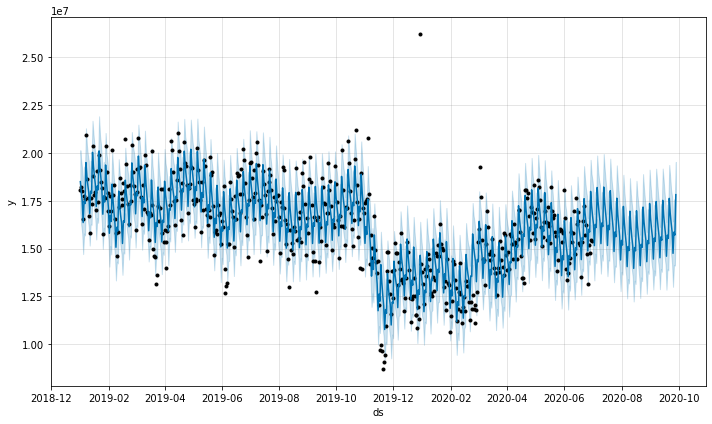

In [19]:
m.plot(df_forecast);

Forecasting each timeseries is taking about 2 seconds. Forecasting a 1000 items would take about 2000 seconds. A little more than half an hour? What if we have 10K items or 100K items? 

## Running Multiple Forecasts with HyperProphet

HyperProphet provides ability to run multiple forecasts at once using an API very close to that of Prophet.

It sends the data to the HyperProphet service where it runs all the forecasts in parallel, combines the results and returns them back.

In [20]:
import hyperprophet as hp

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


The modoule will be initialized by calling `setup` function with `api_token` as argument. 
But that is not required as of now as the service is still in beta.

In [22]:
hp.setup(api_token="dummy")

Hyperprophet expects the column names to be `key`, `ds` and `y`. The `key` uniquely idenfies the timeseries.

In [23]:
df = df.rename(columns={"article": "key", "date": "ds", "pageviews": "y"})

In [24]:
m = hp.Prophet(yearly_seasonality=True, daily_seasonality=True)

In [25]:
m.fit(df)

In [26]:
df_future = m.make_future_dataframe(periods=90)

In [27]:
%%time
df_forecast = m.predict(df_future)

[JOB J265] status=READY progress=0.0
[JOB J265] status=READY progress=0.0
[JOB J265] status=RUNNING progress=0.0
[JOB J265] status=RUNNING progress=0.0
[JOB J265] status=RUNNING progress=0.0
[JOB J265] status=RUNNING progress=0.0
[JOB J265] status=RUNNING progress=0.0
[JOB J265] status=RUNNING progress=100.0
[JOB J265] status=RUNNING progress=100.0
[JOB J265] status=RUNNING progress=100.0
[JOB J265] status=SUCCESS progress=100.0
CPU times: user 1.75 s, sys: 1.14 s, total: 2.9 s
Wall time: 2min 21s


In [28]:
df_forecast.shape

(637000, 17)

Voila! The forecast of the pageviews of all the 1000 articles is ready in about 2 minutes.

HyperProphet is in the early beta right now. We would love to hear about what you think about it. 

Drop a note to us at <hello@hyperprophet.com>

